In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
print("X shape:", X.shape, "- y shape:", y.shape)

X shape: (70000, 784) - y shape: (70000,)


In [5]:
X.iloc[0]

pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Name: 0, Length: 784, dtype: float64

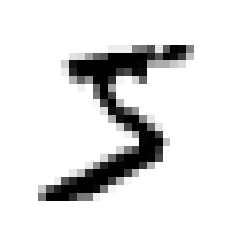

In [6]:
import matplotlib as mpl

some_digit = np.array(X.iloc[0])
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
y[0]

'5'

In [8]:
# converting y from string to int
y = y.astype(np.uint8)
y[0]

5

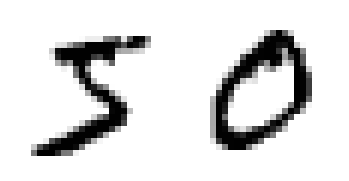

In [9]:
# My attempt at recreating image 3-1, showing some of the various images from the MNIST dataset with the intent 
# of demonstrating how complicated the classification task may be.

img1 = np.array(X.iloc[0]).reshape(28, 28)
img2 = np.array(X.iloc[1]).reshape(28, 28)

img_3 = np.concatenate((img1, img2), axis=1)
plt.axis("off")
plt.imshow(img_3, cmap="binary")

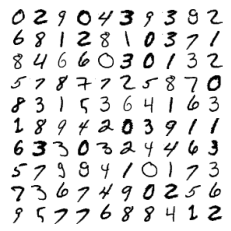

In [10]:
import random as rd

initialized = False
img_total = ''
images = []

for i in range(10):    
    for j in range(10):    
        img = np.array(X.iloc[j+int(100*rd.random())]).reshape(28, 28)
        if not initialized:
            img_total = img
            initialized = True
        else:
            img_total = np.concatenate((img_total, img), axis=1)
    images.append(img_total)
    img_total = ''
    initialized = False
   
full_img = images[0]
for img in images[1:]:
    full_img = np.concatenate((full_img, img), axis=0)

plt.axis("off")
plt.imshow(full_img, cmap="binary")



In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
# Training just for the digit 5
y_train5 = (y_train == 5)
y_test5 = (y_test == 5)

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])
print(sgd_clf.predict([X_train.iloc[9]])[0], y_train[9])

False 4


/home/arthurscarpatto/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"
/home/arthurscarpatto/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [15]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Although the results above are very good, they're still lacking. This is because the classifier is biased and simply classifies everything as "non-5" since it will yield good results every time.

To illustrate the problem, check the below cross validation for the never5classifier. 

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never5classifier = Never5Classifier()
cross_val_score(never5classifier, X_train, y_train5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

This shows that accuracy is not a great way to evaluate classification problems, especially since we're manipulating assimetrical data (that is, when some classes are much more common than others).

A much better way of evaluating these classifiers is by using Confusion Matrixes. Say you want to find out how many times the classifier confused the number 5 with a 3 and classified it as such. You'd then have to look in the fifth line and third column of the confusion matrix.

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [18]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [19]:
y_train_perfect = y_train5

confusion_matrix(y_train5, y_train_perfect)

array([[54579,     0],
       [    0,  5421]])

Confusion matrixes are good but we might prefer more tangible metrics.

For that there is the "classifier's precision", calculated as shown below, where TP is the number of true positives and FP is the number of false positives.

precision = TP/(TP + FP)

_Precision_ is often used together with _recall_, also called _sensibility_ or _true positive rate (TPR)_. This is the proportion of positive instances that are correctly detected by the classifier.

recall = TP/(TP + FN)

Where FN is the number of false negatives.

In [20]:
from sklearn.metrics import precision_score, recall_score

print("Precision score:", precision_score(y_train5, y_train_pred))
print("Recall score:", recall_score(y_train5, y_train_pred))

Precision score: 0.8370879772350012
Recall score: 0.6511713705958311


Now we can see that our classifier is not as good as previously thought. It is correct only 83% of the times. Moreover, it only detects 5s 65% of the times.

A better metric would be the $F_{1}$ $score$, which is a **harmonic** average of precision and recall.

A standard average metric would put equal weights on all values, whereas the harmonic average puts more weight on the lower values. As a result, the classifier will only obtain a good F1 score if recall and precision are high.

$$F_{1} = \frac{2}{(\frac{1}{precision} + \frac{1}{recall})} = 2\cdot\frac{precision \cdot recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}

In [21]:
from sklearn.metrics import f1_score

f1_score(y_train5, y_train_pred)

0.7325171197343846

the $F_{1}$ $score$ is not always the best metric however. For instance, if you're training a model to detect videos that are safe for children, it would be wise to have it reject many good videos (low recall) and keep only the safe ones (high precision), instead of having a classifier that has good recall but keeps many bad videos on the feed (in these cases, there might be a human pipeline to verify the selection of videos from the classifier).

On the other hand, suppose you have a classifier to detect robbers from CCTV footage: it's probably a good thing if the classifier has only 30% precision, as long as it has 99% recall (naturally, the guards will receive some fake alarms, but nearly all the robbers would be caught).

Unfortunately, you cannot have both. When the precision increases, recall decreases and vice-versa. This is called the _precision/recall trade-off_.

In [22]:
# SGDClassifier has a decision_function that allows us to see what values are given to certain predictions
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/home/arthurscarpatto/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([2164.22030239])

In [23]:
# with these values we can create a custom threshold, as displayed below
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
# SGDClassifier uses a default threshold of 0, so the above returns the same result as the predict() method
# We can change this as shown below. This reduces the recall, since the image is a 5 but we're not capturing it with 8000 threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

How to decide which threshold to use? First, we make use of `cross_val_predict()` to obtain scores of all instances in the training set, but this time specify that you want to return the decision scores instead of predictions:

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

With these scores, use `precision_recall_curve()` to calculate the precition and recall of all the possible thresholds:

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train5, y_scores)

Lastly, use **Matplotlib** to plot the precision and recall with respect to the threshold.

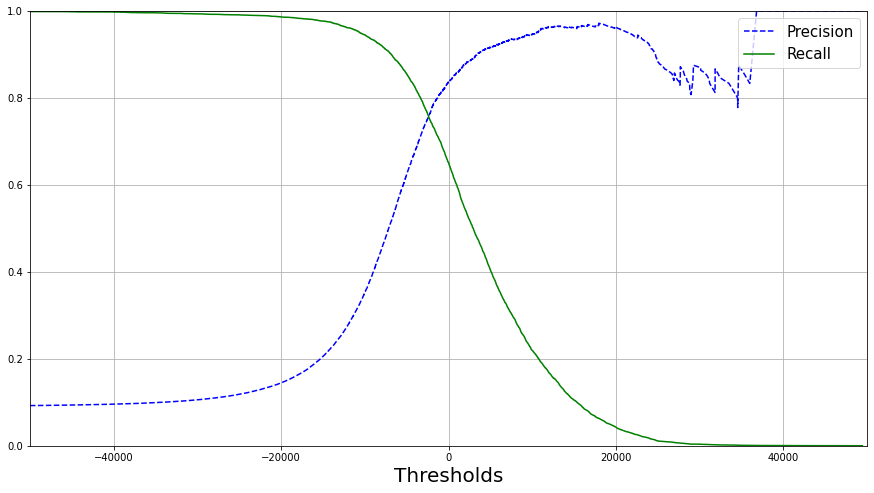

In [27]:
def plot_precision_recall_vs_treshold(precisions, recalls, thresholds):
    plt.figure(figsize=(15, 8))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Thresholds", size=20)
    plt.grid()
    plt.legend(loc="upper right", prop={'size': 15})
    plt.plot(thresholds, )
    plt.ylim(0, 1)
    plt.xlim(-50000, 50000)

plot_precision_recall_vs_treshold(precisions, recalls, thresholds)

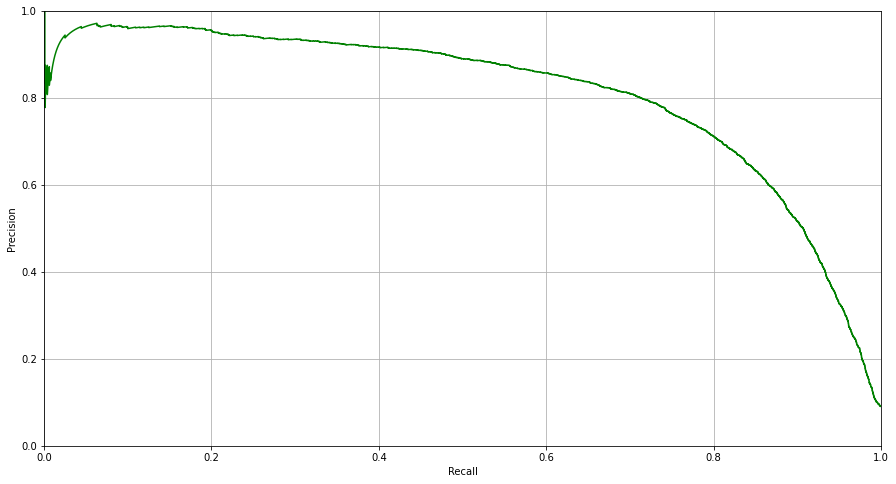

In [28]:
def plot_precision_vs_recall(precisions, recall):
    plt.figure(figsize=(15, 8))
    plt.plot(recall, precisions, "g-")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid()
    plt.xlabel("Recall")
    plt.ylabel("Precision")

plot_precision_vs_recall(precisions, recalls)

Suppose we want a precision of 90%. For that we need to find the value for the smallest threshold that makes the precision reach that percentage. For that, we can use `np.argmax()`, which yields the first index of the maximum value, which in this case is True. 

In [29]:
threshold_90 = thresholds[np.argmax(precisions >= 0.90)]
threshold_90

3370.019499143958

To make predictions, for now, instead of using `predict()` we can use the code below:

In [30]:
y_train_pred_90 = (y_scores >= threshold_90)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [31]:
print("Precision score of 90% threshold:", precision_score(y_train5, y_train_pred_90))
print("Recall score of 90% threshold:", recall_score(y_train5, y_train_pred_90))

Precision score of 90% threshold: 0.9000345901072293
Recall score of 90% threshold: 0.4799852425751706


> In case someone says "Let's reach 99% precision!", ask them: "in what recall?"

Random **$LATEX$** moment!
$$V_{sphere} = \frac{4}{3}\pi r^3$$

I LOVE LATEX!!!!


### The ROC Curve

The **rounded operational characteristic** (ROC) is another common tool on binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision vs recall it represents the _true positive rate_ (another name for recall) in relation to the _false positive rate_ (FPR). The FPR is the proportion of negative instances incorrectly classified as positive. It equals _1 - the rate of true negatives_ (TNR) which is the proportion of negative instances that are correctly classified. The TNR is also called _specificity_. Therefore, the ROC curve plots the _sensibility_ (recall) versus _1 - the specificity_. 

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train5, y_scores)

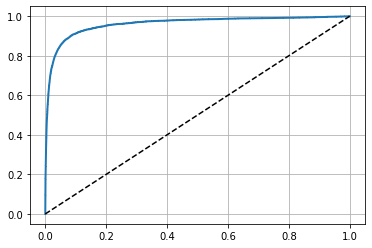

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.grid()
    plt.title(label)

plot_roc_curve(fpr, tpr)

One way of calculating performance for classifiers is by calculating the _area under curve_ (AUC) of the graph above. A perfect classifier will have a ROC AUC of 1, whereas an exclusive random classifier will have a ROC AUC of 0.5. Scikit-Learn has a function to calculate the ROC AUC:

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train5, y_scores)

0.9604938554008616

### PR vs ROC

Use PR when the positive class is rare enough or when the fake positives are more important than the fake negatives. Otherwise, use ROC. For instance, when analyzing the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this basically happens because there are few positives (5s) in comparison to the negatives (not-5s). On the other hand, the PR curve makes it clear that the classifier does have room for upgrades (the curve could be nearer the upper left corner). 

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_prob_forest = cross_val_predict(forest_clf, X_train, y_train5, cv=3, method="predict_proba")